<a href="https://colab.research.google.com/github/Chaohua95/IBM-data-science-Capstone/blob/master/MLP_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import necessary libraries 
import h5py 
import numpy as np 
import matplotlib.pyplot as plt

In [0]:
N_classes= 10
N_input= 128
# define funciton for reading training data
def read_training_set(): 
    # read training data file
    with h5py.File('DataSet/train_128.h5', 'r') as H: 
        data = np.copy(H['data']) 
    # read training labels file
    with h5py.File('DataSet/train_label.h5', 'r') as H: 
        labels = np.copy(H['label']) 
    
    # convert labels to one-hot verctors 
    label_vectors = np.zeros((labels.shape[0], N_classes))
    for i in range(0, labels.shape[0]):
        for j in range(0, N_classes):
            if labels[i,] == j:
                label_vectors[i, j] = 1    
    return data, label_vectors

# define funciton for reading test data
def read_test_data():
    # read test data file
    with h5py.File('../Input/test_128.h5', 'r') as H:
        data = np.copy(H['data'])
    return data

# define function to normalise the data
def normalise(data_set):
    data_size = data_set.shape[0]
    feature_size = data_set.shape[1]
    
    means = data_set.mean(axis=0) #calculate means of each feature 
    stds = data_set.std(axis=0) #calculate standard deviation of each feature
    
    data_normalised = (data_set - means)/stds 
            
    return data_normalised

In [0]:
train_data, train_labels = read_training_set()
train_data = normalise(train_data)


# train_data= train_data[0:1000,:]
# train_labels= train_labels[0:1000,:]

In [0]:
class Activation(object):
    def tanh(self, x):
        return np.tanh(x)

    def tanh_deriv(self, a):
#         a = np.tanh(x)   
        return 1.0 - a**2
    
    def logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
   
    def relu(self, x):
        return (x > 0)*x
    
    def relu_deriv(self, a):
        return (a > 0)
    
    def softmax(self, x):
        return np.exp(x)/sum(np.exp(x))
    
    def softmax_deriv(self, a):
        # a = softmax(x) 
        return  a 

    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.logistic
            self.f_deriv = self.logistic_deriv
        elif activation == 'tanh':
            self.f = self.tanh
            self.f_deriv = self.tanh_deriv
        elif activation == 'relu':
            self.f = self.relu
            self.f_deriv = self.relu_deriv
        elif activation == 'softmax':
            self.f = self.softmax
            self.f_deriv = self.softmax_deriv

In [0]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
  
        self.input=None
        self.activation= Activation(activation).f
        
        self.activation_deriv=None
        if activation_last_layer: #There's another layer before, not input layer
            self.activation_deriv= Activation(activation_last_layer).f_deriv #used to pass the delta on

        #initialize weights
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        self.acc_grad_W= np.zeros(self.W.shape)
        self.acc_grad_b= np.zeros(self.b.shape)
        self.n_in= n_in
        self.n_out= n_out
        self.mask= np.ones(n_out,)

    #unified function calls
    def forward(self, input, dropout, train, output_layer= False): 
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        if train and dropout and not output_layer and self.activation_deriv:
            self.mask= (np.random.binomial(1, (1-dropout), self.n_in)/(1-dropout))
#             self.output *= self.mask 
            input = input * self.mask
        self.input= input
        return self.output
    
    def backward(self, delta, learning_rate, momentum, decay, dropout, output_layer=False): 
#         if dropout and not output_layer and self.activation_deriv:
#             delta= delta * self.mask 
        #(optimize="sgd")
        # Gradient= delta * Input
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if decay: #weight decay
            self.grad_W += decay*self.W
        if self.activation_deriv: #There's another layer before, pass the delta on
            #Next_delta = delta * W * Deriv(layer Input)
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input) #next delta for layer before
        
        if dropout and not output_layer and self.activation_deriv:
            delta= delta * self.mask

        if momentum:
            #(optimize="momentum") One-sample sgd or mini-batch
            self.acc_grad_W = momentum*self.acc_grad_W - learning_rate*self.grad_W
            self.acc_grad_b = momentum*self.acc_grad_b - learning_rate*self.grad_b         
        else:
            #(optimize="sgd",batch_size >1) Mini-batch
            self.acc_grad_W = self.acc_grad_W - learning_rate*self.grad_W
            self.acc_grad_b = self.acc_grad_b - learning_rate*self.grad_b
        return delta
    
    

In [0]:
class MLP:     
    def __init__(self, layers, activation=[None,'tanh','tanh']):
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation= activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1])) 
    
    def forward(self,input, dropout=0, train= False):
        output_layer= False
        for layer in self.layers:
            if layer == self.layers[-1]: output_layer= True
            output=layer.forward(input, dropout, train, output_layer)
            input=output
        return output
    
    def MSE(self,y,y_hat,decay):                
        activation_deriv= Activation(self.activation[-1]).f_deriv        
        error = y_hat-y #mse
        l2= decay*(self.layers[-1].W**2).sum() / 2 
        loss= (error**2).sum()  +  l2
        delta= error*activation_deriv(y_hat)  # calculate delta of the output layer
        return loss,delta
    
    def crossEntropy(self,y,y_hat,decay):
        #softmax
        if round(sum(y_hat)) != 1.:
            y_hat= np.exp(y_hat)/sum(np.exp(y_hat))
        #cross Entropy    
        activation_deriv= Activation(self.activation[-1]).f_deriv
        l2= decay*(self.layers[-1].W**2).sum() / 2
        loss= -1*np.dot(y, np.log(y_hat+1e-7)) + l2
        error= y_hat-y #with softmax
        delta= error # calculate delta of the output layer
        return loss,delta   
        
    def backward(self,delta, learning_rate, momentum, decay, dropout):
        delta=self.layers[-1].backward(delta, learning_rate, momentum, decay, dropout, output_layer=True)#back propagate outer delta
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta, learning_rate, momentum, decay, dropout)#back propagate delta
            
    def update(self,lr, momentum, batch_size):
        if not momentum:
            #(optimize="sgd")
            for layer in self.layers:
                layer.W -= lr * layer.grad_W
                layer.b -= lr * layer.grad_b
        else:
            #(optimize="momentum") One-sample sgd or mini-batch
            for layer in self.layers:
                layer.W += layer.acc_grad_W
                layer.b += layer.acc_grad_b
            #mini-batch reset (batch_size > 1)
            if batch_size > 1:
                for layer in self.layers:
                    layer.acc_grad_W = np.zeros(layer.acc_grad_W.shape)
                    layer.acc_grad_b= np.zeros(layer.acc_grad_b.shape)
    
    def predict(self, x): 
        x = np.array(x)
        output = []
        for i in np.arange(x.shape[0]):
            output.append(self.forward(x[i,:]))
        return np.array(output)
    
    def fit(self,X,y, optimize= "sgd", regularize= None, cost= "mse", dropout= 0.5,
            decay= 0.001, batch_size= 1, learning_rate=0.1, momentum= 0.9, epochs=250):
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)  
        if optimize != "momentum": #sgd 
            momentum= None
        if regularize !="wd":
            decay= 0
        if regularize != "dropout":
            dropout= 0
            
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            
            #shuffle index------------------------------------------------
            index_shuf = list(range(X.shape[0]))
            np.random.shuffle(index_shuf)
            n_batches = X.shape[0] // batch_size
            j= 0
            for i in range(n_batches): 
                X_batch= X[index_shuf[i * batch_size:(i + 1)*batch_size], :]
                y_batch= y[index_shuf[i * batch_size:(i + 1)*batch_size], :]
                
                #inside batch---------------------------------------------
                for i2 in range(batch_size):
                    # forward pass
                    y_hat = self.forward(X_batch[i2,:], dropout, train= True)
                    if cost=="crossentropy":                    
                        loss[j],delta=self.crossEntropy(y_batch[i2,:],y_hat,decay)
                        if(np.isnan(loss[j])): return to_return[0:k-1]
                    else:
                        loss[j],delta=self.MSE(y_batch[i2,:],y_hat,decay)
                        if(np.isnan(loss[j])): return to_return[0:k-1]
                    j+=1
                    # backward pass    
                    self.backward(delta, learning_rate, momentum, decay, dropout)
                    
                # update--------------------------------------------------
                self.update(learning_rate, momentum, batch_size)
            to_return[k] = np.mean(loss)  
            print('loss at epoch ' + str(k) + ": " + str(to_return[k]))
        return to_return    
       
   

In [0]:
### Try different MLP models
nn = MLP([N_input, 64, 32, 16, N_classes], [None,'relu', 'relu', 'relu', 'softmax'])

In [0]:
### Try different learning rate and epochs
MSE = nn.fit(train_data,train_labels, optimize= "momentum", cost= "crossentropy",  regularize= "dropout", dropout= 0.1,
             batch_size= 200, learning_rate=0.01, epochs=50)
print('loss:%f'%MSE[-1])

loss at epoch 0: 1.306962728142269
loss at epoch 1: 0.6223788034869322
loss at epoch 2: 0.5294123420893421
loss at epoch 3: 0.4868005905859126
loss at epoch 4: 0.4629800978071907
loss at epoch 5: 0.4416570742677548
loss at epoch 6: 0.424252223087295
loss at epoch 7: 0.41218474212895717
loss at epoch 8: 0.40459305974403287
loss at epoch 9: 0.39299041883555286
loss at epoch 10: 0.39135640766679886
loss at epoch 11: 0.3816350107056029
loss at epoch 12: 0.379046244824506
loss at epoch 13: 0.3799642890590786
loss at epoch 14: 0.373706473213852
loss at epoch 15: 0.3653861906985298
loss at epoch 16: 0.3705965200792302
loss at epoch 17: 0.36924765263360654
loss at epoch 18: 0.34942801394922707
loss at epoch 19: 0.3473971593530204
loss at epoch 20: 0.3431924556390626
loss at epoch 21: 0.3478143789838454
loss at epoch 22: 0.3432238064317335
loss at epoch 23: 0.3369587127674719
loss at epoch 24: 0.3328370604658605
loss at epoch 25: 0.32950972301642134
loss at epoch 26: 0.3273344970270294
loss at 

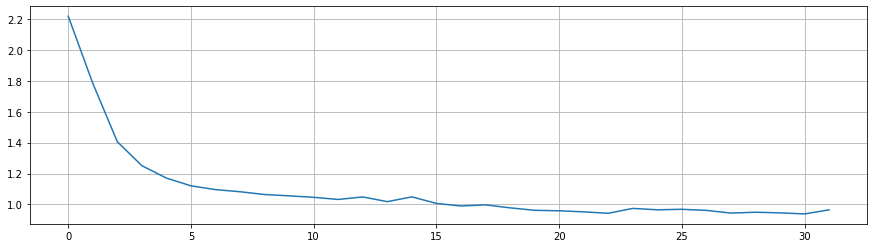

In [0]:
plt.figure(figsize=(15,4))
plt.plot(MSE)
plt.grid()

In [0]:
train_labels2= np.argmax(train_labels, axis=1)
output = nn.predict(train_data)
output= np.argmax(output, axis=1)
print(sum(output==train_labels2)/len(output))


0.8229166666666666
